In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import healpy as hp
import mastcasjobs

##### Here we plot the 592 PS1-ELQS quasars obtained from Schindler et al. 2019 in a mollweide projection sky map.

In [144]:
def range_wrapper(arr):
    '''Converts the range of (0 deg to 360 deg) to 
        (-180 deg to 180 deg) with 0 deg matching'''
        
    arr[np.where(arr > 180)] = arr[np.where(arr > 180)] - 360
    arr = -arr
    return arr

def plot_sky_map_ps1(ra, dec):
    '''Give right ascension in array of decimal degrees (0 deg to 360 deg)
        and declination in array of decimal degrees (-90 deg to 90 deg)'''

    ra = np.radians(range_wrapper(ra))
    dec = np.radians(dec)

    plt.figure(figsize = (12, 7))
    ax = plt.subplot(111, projection = "mollweide")
    plt.scatter(ra, dec, marker = 'o', color = 'red', s = 10)
    plt.title("PS1-ELQS Catalogue")
    plt.grid(True)

    ax.set_xticklabels(["10h", "8h", "6h", "4h", "2h", "0h", "22h", "20h", "18h", "16h", "14h"]);
    plt.show()

In [145]:
schind_file_name = "apjsab20d0t7_mrt.txt"
shind_file = open(schind_file_name, 'r')
schind_data = ascii.read(schind_file_name)
ra_col = schind_data.columns[1]
dec_col = schind_data.columns[2]

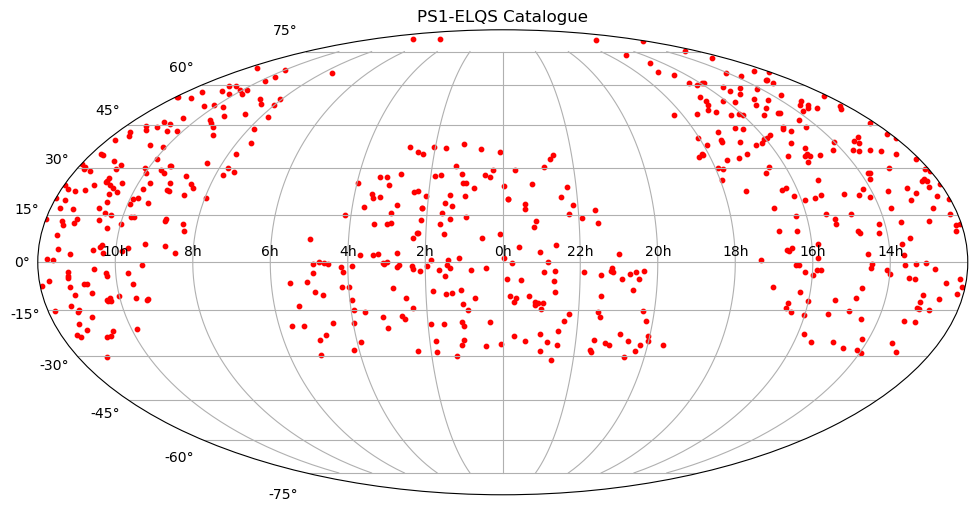

In [146]:
plot_sky_map_ps1(ra_col, dec_col)

##### Here we are attempting to obtain the PS1-ELQS footprint using **healpy** (HEALpix; Gorski et al. 2005) tools

In [147]:
def healpix_sky_map_ps1_cover_area(ra, dec, level):
    nside = 2 ** level

    ra_values = np.radians(ra)
    dec_values = np.absolute(np.radians(dec) - np.pi/2)

    pixel_indices = hp.ang2pix(nside, dec_values, ra_values)

    npixels = hp.nside2npix(nside)
    all_pixels = np.zeros(npixels)
    all_pixels[pixel_indices] = 1

    pixels_with_data = np.shape(np.where(all_pixels != 0))[1]
    area_data_pixels = pixels_with_data * hp.nside2pixarea(nside, degrees=True)

    hp.mollview(all_pixels)
    return area_data_pixels


Effective area covered by the data is 490.987 deg^2


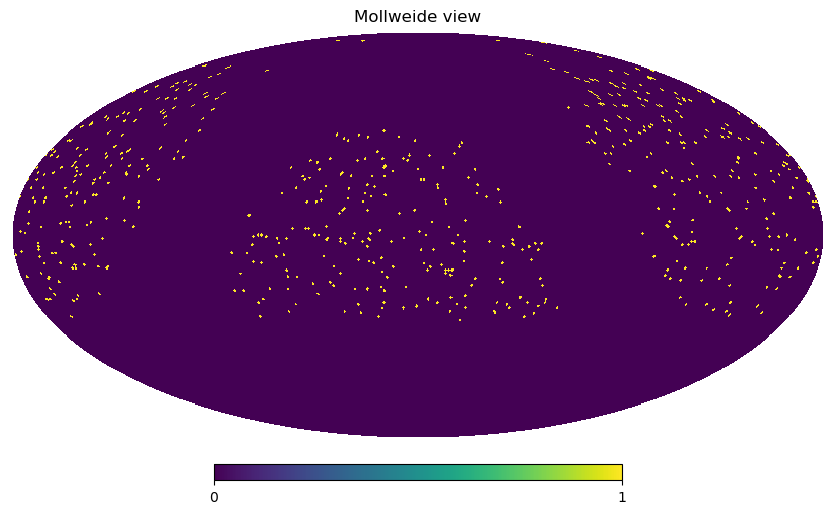

In [148]:
effective_area = healpix_sky_map_ps1_cover_area(ra_col, dec_col, 6)
print("Effective area covered by the data is {:.3f} deg^2".format(effective_area))

##### Above we included only the 592 quasars in the HEALpix estimate. Now let's add all the targets from the JKW2 color cut of PS1.

In [3]:
query = """SELECT	
        m.wise_designation, m.wise_ra, m.wise_dec,	
        o.ObjID as PS1_ObjID,x.ra as ps_ra,x.dec as ps_dec,	
        o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanKronMag, o.gMeanApMag,	
        o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanKronMag, o.rMeanApMag,	
        o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanKronMag, o.iMeanApMag,	
        o.zMeanPSFMag, o.zMeanPSFMagErr, o.zMeanKronMag, o.zMeanApMag,	
        o.yMeanPSFMag, o.yMeanPSFMagErr, o.yMeanKronMag, o.yMeanApMag,	
        o.gMeanPSFmagNpt,o.rMeanPSFmagNpt,o.iMeanPSFmagNpt,o.zMeanPSFmagNpt,o.yMeanPSFmagNpt,	
        o.gFlags, o.gQfPerfect,	
        o.rFlags, o.rQfPerfect,	
        o.iFlags, o.iQfPerfect,	
                
        o.zFlags, o.zQfPerfect,	
        o.yFlags, o.yQfPerfect,	
        sp.gpetRadius,sp.rpetRadius,sp.ipetRadius,sp.zpetRadius,sp.ypetRadius,	
        sot.iinfoFlag, sot.iinfoFlag2	
                
                
        into mydb.wise_2mass_jkw2_colorcut_matched	
        from mydb.wise_2mass_jkw2_colorcut AS m	
                
        CROSS APPLY (SELECT * FROM dbo.fGetNearestObjEq(m.wise_ra,m.wise_dec,0.066)) AS x	
        JOIN MeanObject o on o.ObjID = x.ObjId	
                
        LEFT JOIN StackPetrosian AS sp ON sp.objID = o.objID	
        LEFT JOIN StackObjectThin AS sot ON sot.objID = o.objID	
                
        WHERE (o.iMeanPSFMag > 0 AND o.iMeanPSFMag <= 19.0)	
        AND o.zMeanPSFMag > 0	
        AND o.yMeanPSFMag > 0	
        AND o.iQfPerfect >= 0.85 and o.zQfPerfect >= 0.85	
        --- rejects extended objects	
        AND (-0.3 <= iMeanPSFMag - iMeanApMag OR iMeanPSFMag - iMeanApMag <= 0.3)	
        --- photometric quality criteria	
        AND (sot.iinfoFlag & 0x00000008 = 0) ---FAIL	
        AND (sot.iinfoFlag & 0x00000010 = 0) ---POOR/POORFIT	
        AND (sot.iinfoFlag & 0x00000020 = 0) ---PAIR	
        AND (sot.iinfoFlag & 0x00000080 = 0) ---SATSTAR	
        AND (sot.iinfoFlag & 0x00000100 = 0) ---BLEND	
        AND (sot.iinfoFlag & 0x00000400 = 0) ---BADPSF	
        AND (sot.iinfoFlag & 0x00000800 = 0) ---DEFECT	
        AND (sot.iinfoFlag & 0x00001000 = 0) ---SATURATED	
        AND (sot.iinfoFlag & 0x00002000 = 0) ---CR_LIMIT	
        AND (sot.iinfoFlag & 0x00008000 = 0) ---MOMENTS_FAILURE	
        AND (sot.iinfoFlag & 0x00010000 = 0) ---SKY_FAILURE	
        AND (sot.iinfoFlag & 0x00020000 = 0) ---SKYVAR_FAILURE	
        AND (sot.iinfoFlag & 0x00040000 = 0) ---MOMENTS_SN	
        AND (sot.iinfoFlag & 0x00400000 = 0) ---BLEND_FIT	
        AND (sot.iinfoFlag & 0x10000000 = 0) ---SIZE_SKIPPED	
        AND (sot.iinfoFlag & 0x20000000 = 0) ---ON_SPIKE	
        AND (sot.iinfoFlag & 0x40000000 = 0) ---ON_GHOST	
        AND (sot.iinfoFlag & 0x80000000 = 0) ---OFF_CHIP	
        AND (sot.iinfoFlag2 & 0x00000008 = 0) ---ON_SPIKE	
        AND (sot.iinfoFlag2 & 0x00000010 = 0) ---ON_STARCORE	
        AND (sot.iinfoFlag2 & 0x00000020 = 0) ---ON_BURNTOOL	
        """

jobs = mastcasjobs.MastCasJobs(username = "vibin.narayanan", password = "vibinps1pwd", context = "PanSTARRS_DR2")
ps1_jkw2_cut = jobs.submit(query, task_name = "PS1 jkw2 color cut")

Exception: SubmitJob failed with status: 404
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">